In [30]:
from util import get_freq
import matplotlib.pyplot as plt
import numpy as np
from random import uniform
from NPSmethods import readInImages
from NPSmethods import pupilFunc
from numpy.fft import ifftshift, irfft2
import pickle as pkl

In [40]:
#Geranate random assortment of parameters
def make_Paras(seedParas, numToGen):
    outPara = np.empty(shape =(numToGen, len(seedParas)))
    paraTemp = [None] * len(seedParas)
    for i in range(numToGen):
        for j in range(len(seedParas)):
            para = seedParas[j]
            if j ==3 or j == 5 or j == 6:
                para = uniform(para*.5, para*2)
            paraTemp[j] = para
        outPara[i] = paraTemp
    return outPara
        

#Generate M2k_Fit
def make_M2k_Fit(paras, imgSysData):
    
    A, tau, S0, alpha, phi, beta, delta_s = paras
    _, _, K_X, K_Y = get_freq(imgSysData["CCDPixelSize"],
                                      imgSysData["magnification"], (100,100))
    d = imgSysData["wavelen"] / (2*np.pi*imgSysData["NA"])
    R_p, Theta_p = np.abs(K_X + 1j*K_Y) * d, np.angle(K_X + 1j*K_Y)
    p1 = pupilFunc(R_p, Theta_p + np.pi, tau, S0, alpha, phi, beta)
    p2 = np.conj(pupilFunc(R_p, Theta_p, tau, S0, alpha, phi, beta)) * \
            np.exp(-2*1j*delta_s)
    PSF = (p1 + p2) / (2 * np.cos(delta_s))
    M2k = np.abs(PSF)**2
    M2k_Fit = A * M2k
    
    return M2k_Fit

#Generate NPS noise
def generate_Noise(M2k_Fit, idealOD, numIms):
    M2k_Fit *= idealOD.sum()
    M2k_Fit = M2k_Fit.flatten()
    NPSs = np.empty(shape = (numIms, len(M2k_Fit)))
    
    for i in range(len(M2k_Fit)):
        NPSs_temp = np.zeros_like(M2k_Fit)
        SNR = range(2, 2+numIms, 1)
        noise = np.random.normal(0, 1, size = len(M2k_Fit))

        for j in range(numIms):
            NPSs[j][i] = M2k_Fit[i] + np.mean(M2k_Fit[M2k_Fit != 0]) * noise[i] / SNR[j]

    NPSs = np.reshape(NPSs, (numIms, 100, 100))
    
    return NPSs

#Turn one NPS to one OD
def NPS_to_ODs(NPSs):
    fakeODs = np.empty_like(NPSs[0])
    
    for NPS in NPSs:
        NPS = np.sqrt(np.abs(NPS))
        noise = ifftshift(irfft2(ifftshift(NPS), s = np.shape(NPSs[0])))
        fakeODs = np.dstack((fakeODs, np.exp(-(noise + idealOD))))

    fakeODs = fakeODs.T
    fakeODs = np.delete(fakeODs, 0, 0)
    
    return fakeODs

In [41]:
folderpath = './raw_image/141902/'
savepath = './results/141902_101-123/'
seedParas = [0.35060326843236184, 0.6484441665068852, -2.63564159087613, 0.5094606166480791, -1.8773441762223027, 0.8206242586655179, 1.0257364487180909]

numNPSs = 50
numODs = 50
numParas = 10

NPSs = np.empty(shape = (numNPSs, 100, 100))
fakeODs = np.empty(shape = (numNPSs, 100, 100))

_, idealOD, _, _, _, _ = readInImages(folderpath, 23, 0, trapRegion = (slice(100, 200), slice(100, 200)), noiseRegion = (slice(0, 300), slice(0, 300)))

imgSysData = { 
    "CCDPixelSize": 13,      # pixel size of the CCD, in micron 
    "magnification": 27,      # 799.943 / 29.9099, # magnification of the imaging system 
    "wavelen"     : 0.852,     # wavelength of the imaging beam, in micron 
    "NA"          : 0.37,      # numerical aperture of the objective 
    "ODtoAtom"    : 13
} 

i = 0
for paras in make_Paras(seedParas, numParas):
    i += 1
    print(i)
    NPSs = np.vstack((NPSs, generate_Noise(make_M2k_Fit(paras, imgSysData), idealOD, numNPSs)))
NPSs = NPSs[numNPSs:]
fakeODs = np.vstack((fakeODs, NPS_to_ODs(NPSs)))
fakeODs = fakeODs[numODs:]

1
2
3
4
5
6
7
8
9
10


In [42]:
print(np.shape(NPSs))
print(np.shape(fakeODs))

(500, 100, 100)
(500, 100, 100)


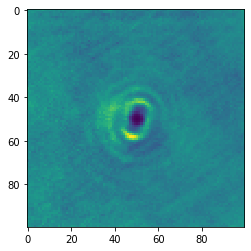

In [81]:
fig, ax = plt.subplots()
# odavg = np.mean(fakeODs[0:49], axis = 0)
# im = ax.imshow(odavg)
im = ax.imshow(fakeODs[299])

In [66]:
pkl.dump(NPSs, open(savepath + "fakeNPSs", "wb"))
pkl.dump(fakeODs, open(savepath + "fakeODs", "wb"))